### Dataset Preview (first 5 rows) ###


/var/folders/dh/vh_kvsnj41q6877kxnwy1c040000gn/T/ipykernel_5542/950625956.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
/var/folders/dh/vh_kvsnj41q6877kxnwy1c040000gn/T/ipykernel_5542/950625956.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')


,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2023-12-29,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,2023-12-28,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,2023-12-27,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,2023-12-26,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,2023-12-22,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


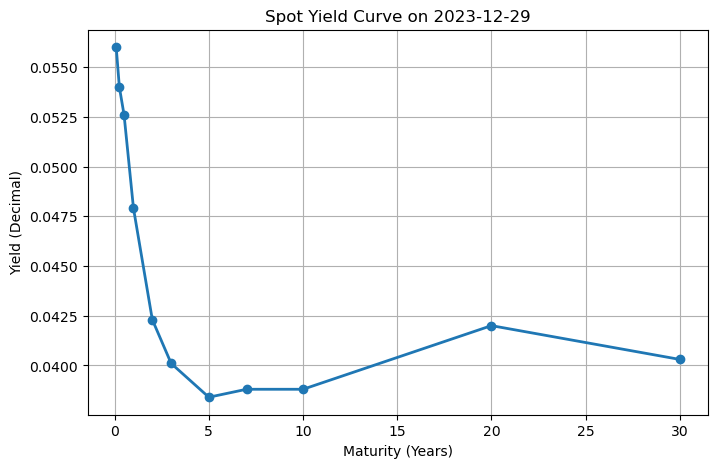

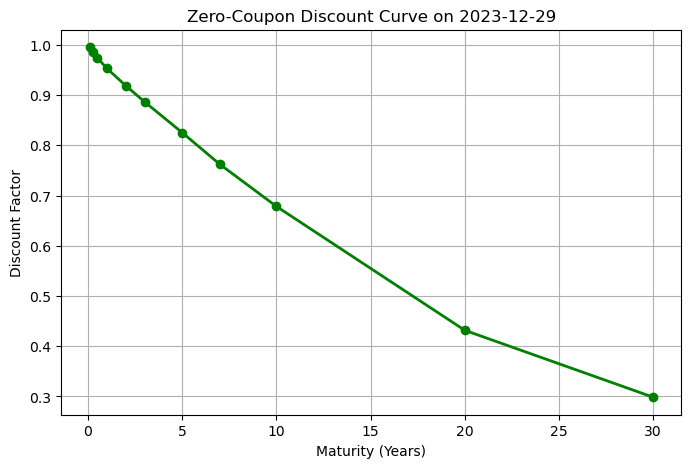

In [4]:
# Fixed Income Risk Analytics Portfolio Project

# -----------------------------------------------------------
# 📚 1. Setup and Data Loading
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load and parse date with format inference
file_path = "yield-curve-rates-1990-2023.csv.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
df = df.dropna(subset=['Date'])

# Select relevant maturity columns and convert terms to years
maturity_columns = [
    '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr',
    '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'
]
terms_in_years = {
    '1 Mo':  1/12,
    '3 Mo':  3/12,
    '6 Mo':  6/12,
    '1 Yr':  1,
    '2 Yr':  2,
    '3 Yr':  3,
    '5 Yr':  5,
    '7 Yr':  7,
    '10 Yr': 10,
    '20 Yr': 20,
    '30 Yr': 30
}

print("### Dataset Preview (first 5 rows) ###")
display(df.head())

# -----------------------------------------------------------
# 🗓️ 2. Build Spot Yield Curve for a Selected Date
# -----------------------------------------------------------
latest_date = df['Date'].max()
latest_curve = df.loc[df['Date'] == latest_date, maturity_columns].iloc[0]
spot_terms = np.array([terms_in_years[m] for m in latest_curve.index], dtype=float)
spot_yields = np.array(latest_curve.values, dtype=float) / 100.0  # decimal form

plt.figure(figsize=(8, 5))
plt.plot(spot_terms, spot_yields, marker='o', linewidth=2)
plt.title(f"Spot Yield Curve on {latest_date.date()}")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (Decimal)")
plt.grid(True)
plt.show()

# -----------------------------------------------------------
# 🏦 3. Zero-Coupon Bond Pricing Engine
# -----------------------------------------------------------
def price_zero_coupon(yields, terms):
    """
    Price zero-coupon bonds using continuous compounding.
    P(t,T) = exp(-y(t,T) * (T - t))
    """
    yields_arr = np.array(yields, dtype=float)
    terms_arr = np.array(terms, dtype=float)
    return np.exp(-yields_arr * terms_arr)

discount_factors = price_zero_coupon(spot_yields, spot_terms)

plt.figure(figsize=(8, 5))
plt.plot(spot_terms, discount_factors, marker='o', color='green', linewidth=2)
plt.title(f"Zero-Coupon Discount Curve on {latest_date.date()}")
plt.xlabel("Maturity (Years)")
plt.ylabel("Discount Factor")
plt.grid(True)
plt.show()

5Y Bond Price    = $104.7246
Duration         = 4.5609 years
Convexity        = 21.9418
Shifted Price (Exact) = $100.0612
Approx ΔPrice        = $-4.6615 (-4.45%)
Actual ΔPrice        = $-4.6633 (-4.45%)
5-30Y Par Swap Rate = 17.58%
Payer Swap Value     = $0.0000
Receiver Swap Value  = $-0.0000
10Y Bond Price    = $108.3963
10Y Duration      = 8.2000 years
10Y Convexity     = 75.7190
Duration Hedge Ratio (q) = -0.5374
Initial Hedge Portfolio = $46.4764
Shifted Hedge Portfolio    = $46.3758
ΔValue (Hedged)            = $-0.1006
ΔValue (Unhedged 5Y Bond)   = $-4.6633

📊 Key Instrument Metrics (Spot & Post-Shift):


,Instrument,Price,Duration,Convexity,Shifted Price,Approx Δ% (5Y),Payer Swap Value
0,5Y Bond,104.724558,4.560869,21.941845,100.061246,-4.451159,NaN
1,10Y Bond,108.396308,8.200007,75.719047,99.905368,NaN,NaN
2,Payer Swap,NaN,NaN,NaN,NaN,NaN,0.0


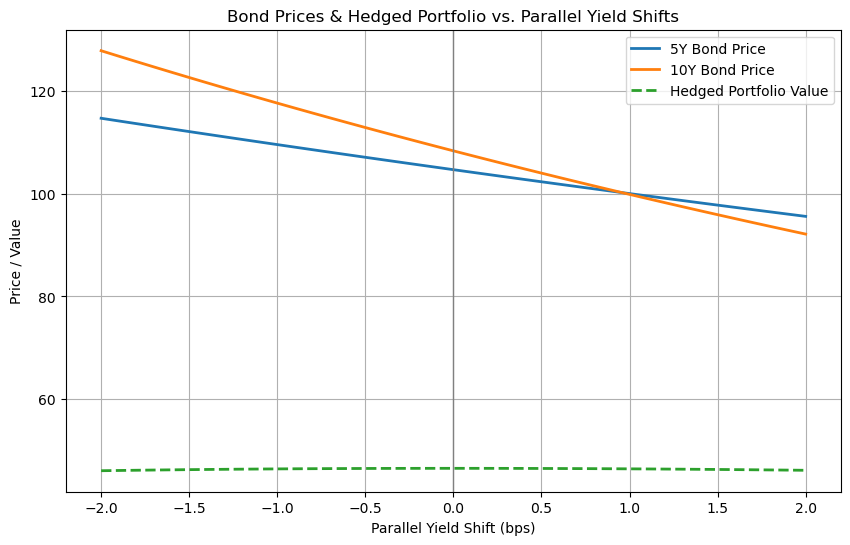

In [6]:
# -----------------------------------------------------------
# 🧮 4. Duration & Convexity Functions
# -----------------------------------------------------------
def duration_convexity(cashflows, times, yields):
    """
    Compute bond price, duration, and convexity for fixed-cashflow bond.
    """
    cf_arr = np.array(cashflows, dtype=float)
    times_arr = np.array(times, dtype=float)
    yields_arr = np.array(yields, dtype=float)
    pv = cf_arr * np.exp(-yields_arr * times_arr)
    price = np.sum(pv)
    duration = np.sum(times_arr * pv) / price
    convexity = np.sum((times_arr**2) * pv) / price
    return price, duration, convexity

# -----------------------------------------------------------
# 🔍 5. Example: Pricing a 5-Year Fixed-Coupon Bond
# -----------------------------------------------------------
notional = 100
coupon_rate = 0.05
payment_times = np.array([1, 2, 3, 4, 5], dtype=float)
cashflows = np.array([notional * coupon_rate] * 4 + [notional * (1 + coupon_rate)], dtype=float)

# Interpolate spot yields for payment times
interp_yields = np.interp(payment_times, spot_terms, spot_yields)

bond_price, bond_duration, bond_convexity = duration_convexity(cashflows, payment_times, interp_yields)
print(f"5Y Bond Price    = ${bond_price:.4f}")
print(f"Duration         = {bond_duration:.4f} years")
print(f"Convexity        = {bond_convexity:.4f}")

# -----------------------------------------------------------
# 📈 6. Yield Curve Shift Simulation (+100 bps)
# -----------------------------------------------------------
delta_y = 0.01  # 100 basis points
shifted_price = np.sum(cashflows * np.exp(-(interp_yields + delta_y) * payment_times))
approx_pct_change = -bond_duration * delta_y + 0.5 * bond_convexity * (delta_y**2)
approx_price_change = approx_pct_change * bond_price
actual_pct_change = (shifted_price - bond_price) / bond_price

print(f"Shifted Price (Exact) = ${shifted_price:.4f}")
print(f"Approx ΔPrice        = ${approx_price_change:.4f} ({approx_pct_change*100:.2f}%)")
print(f"Actual ΔPrice        = ${(shifted_price - bond_price):.4f} ({actual_pct_change*100:.2f}%)")

# -----------------------------------------------------------
# 💱 7. Interest Rate Swap Calculation & Valuation
# -----------------------------------------------------------
def calc_swap_rate(discounts, delta):
    """
    Compute par swap rate K given discount factors:
    K = [P(t,T0) - P(t,Tn)] / [delta * Σ P(t,Ti)]
    """
    disc = np.array(discounts, dtype=float)
    numer = disc[0] - disc[-1]
    denom = delta * np.sum(disc)
    return numer / denom

# Select discount factors for 5, 7, 10, 20, 30-year nodes
selected_mats = [5, 7, 10, 20, 30]
idxs = [list(spot_terms).index(t) for t in selected_mats]
swap_discounts = discount_factors[idxs]
delta = 1  # annual payments
swap_rate = calc_swap_rate(swap_discounts, delta)
print(f"5-30Y Par Swap Rate = {swap_rate*100:.2f}%")

def swap_value_payer(notional, fixed_rate, discounts, delta):
    """
    Value of a payer swap (pay fixed, receive floating):
    V = N * [P(t,T0) - P(t,Tn) - delta*K * Σ P(t,Ti)]
    """
    disc = np.array(discounts, dtype=float)
    pv_float = disc[0] - disc[-1]
    pv_fixed = fixed_rate * delta * np.sum(disc)
    return notional * (pv_float - pv_fixed)

payer_swap_value = swap_value_payer(notional, swap_rate, swap_discounts, delta)
print(f"Payer Swap Value     = ${payer_swap_value:.4f}")
print(f"Receiver Swap Value  = ${-payer_swap_value:.4f}")

# -----------------------------------------------------------
# ⚖️ 8. Duration-Only Hedging Simulation (Corrected)
# -----------------------------------------------------------
ten_yr_times = np.arange(1, 11, dtype=float)
ten_yr_cashflows = np.concatenate([
    np.repeat(notional * coupon_rate, 9),
    [notional * (1 + coupon_rate)]
])
ten_yr_interp_yields = np.interp(ten_yr_times, spot_terms, spot_yields)
ten_price, ten_duration, ten_convexity = duration_convexity(
    ten_yr_cashflows,
    ten_yr_times,
    ten_yr_interp_yields
)

print(f"10Y Bond Price    = ${ten_price:.4f}")
print(f"10Y Duration      = {ten_duration:.4f} years")
print(f"10Y Convexity     = {ten_convexity:.4f}")

q_duration = - (bond_duration * bond_price) / (ten_duration * ten_price)
print(f"Duration Hedge Ratio (q) = {q_duration:.4f}")

port_initial_value = bond_price + q_duration * ten_price
print(f"Initial Hedge Portfolio = ${port_initial_value:.4f}")

# Apply +100bps shift to 10Y bond as well
ten_shifted_yields = ten_yr_interp_yields + delta_y
ten_price_shifted  = np.sum(ten_yr_cashflows * np.exp(-ten_shifted_yields * ten_yr_times))

# Use shifted_price for 5Y bond
port_shifted_value = shifted_price + q_duration * ten_price_shifted

print(f"Shifted Hedge Portfolio    = ${port_shifted_value:.4f}")
print(f"ΔValue (Hedged)            = ${port_shifted_value - port_initial_value:.4f}")

unhedged_delta = shifted_price - bond_price
print(f"ΔValue (Unhedged 5Y Bond)   = ${unhedged_delta:.4f}")

# -----------------------------------------------------------
# 🧾 9. Summary of Key Results in a Table (No ace_tools)
# -----------------------------------------------------------
results = {
    "Instrument": ["5Y Bond", "10Y Bond", "Payer Swap"],
    "Price": [bond_price, ten_price, np.nan],
    "Duration": [bond_duration, ten_duration, np.nan],
    "Convexity": [bond_convexity, ten_convexity, np.nan],
    "Shifted Price": [shifted_price, ten_price_shifted, np.nan],
    "Approx Δ% (5Y)": [approx_pct_change * 100, np.nan, np.nan],
    "Payer Swap Value": [np.nan, np.nan, payer_swap_value]
}

results_df = pd.DataFrame(results)
print("\n📊 Key Instrument Metrics (Spot & Post-Shift):")
display(results_df)

# -----------------------------------------------------------
# 🗒️ 10. Plot: Portfolio Value vs. Yield Shifts (±200bps)
# -----------------------------------------------------------
shift_range = np.linspace(-0.02, 0.02, 41)  # -200bps to +200bps
prices_5y = [
    np.sum(cashflows * np.exp(-(interp_yields + s) * payment_times))
    for s in shift_range
]
prices_10y = [
    np.sum(ten_yr_cashflows * np.exp(-(ten_yr_interp_yields + s) * ten_yr_times))
    for s in shift_range
]
hedged_vals = [
    prices_5y[i] + q_duration * prices_10y[i]
    for i in range(len(shift_range))
]

plt.figure(figsize=(10, 6))
plt.plot(shift_range * 100, prices_5y, label="5Y Bond Price", linewidth=2)
plt.plot(shift_range * 100, prices_10y, label="10Y Bond Price", linewidth=2)
plt.plot(shift_range * 100, hedged_vals, label="Hedged Portfolio Value", linestyle='--', linewidth=2)
plt.axvline(0, color='gray', linewidth=1)
plt.title("Bond Prices & Hedged Portfolio vs. Parallel Yield Shifts")
plt.xlabel("Parallel Yield Shift (bps)")
plt.ylabel("Price / Value")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------
# 🎉 End of Notebook
# -----------------------------------------------------------